<a href="https://colab.research.google.com/github/uvaroall/diamonds/blob/main/diamonds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook для задания 1

# Постановка задачи и выбор метрики

**Предсказать цветность бриллианта**

Тип задачи: классификация.

Используем метрику Многоклассовая классификация - F1-мера, поскольку для бриллианта необходимо предсказать один из 7 классов цветности. Итоговое значение метрики из матриц ошибок - macro: заранее не знаем, насколько сбалансированы классы.

1. *Карат - это мера веса бриллианта.*
2. *Огранка имеет 5 уровней: "Допустимая", "Хорошая", "Очень хорошая", "Премиум", "Идеальная".*
3. *Бесцветные бриллианты считаются лучше, чем бриллианты с желтым оттенком. Градация включает в себя 7 уровней. Бриллианты "D" - "F" считаются бесцветными, а бриллианты "G" - "J" имеют цвет.*
2. *Чистота имеет 8 уровней, от "I1" (наихудший) до "IF" (наилучший).*
3. *x, y, z, depth и table - различные показатели размера бриллианта в миллиметрах.*

Источник данных: https://www.kaggle.com/datasets/joebeachcapital/diamonds

# Подключение библиотек, чтение данных из файла, оценка полноты набора данных

In [159]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
%matplotlib inline
import random
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diamonds.csv')
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Проверка базовых характеристик набора данных  

* Определяем размер датафрейма  
* Результат проверки типа данных в столбцах: есть объекты Object, потребуется применение категориальных переменных
* Результат проверки пустых ячеек: 0 пустых ячеек, дополнительная обработка массива данных не нужна



In [160]:
df.shape

(53940, 10)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [162]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

# Визуализации и экспресс-аналитика

Рассмотрим облака точек параметров, сопоставленных каратности бриллиантов.

Интересна диаграмма зависимости цены от каратности: с одной стороны, очевидна положительная корелляция этих параметров (тяжёлый бриллиант больше стоит). С другой стороны, видно, что бриллианты меньшей массы могут стоить наравне с образцами в 3 раза тяжелее их -- следовательно, они хороши и по остальных характеристикам. Если тяжёлый бриллиант стоит ниже ожидаемого, вероятно, у него будут недостатки материала или огранки.

Эта мысль дополняется остальными диаграммами, демонстрирующими возможность комбинаций всех параметров со всеми.

Теоретически из набора данных могут быть исключены колонки x, y, z, depth и table, так как комбинация габаритных характеристик через плотность связана с каратностью бриллианта. Однако мы предполагаем, что комбинация этих параметров может дополнять данные об огранке кристаллов, поэтому исключать их не будем.

Для постоения гистограмм применим LabelEncoder для объектов, выраженных строковыми значениями.

In [163]:
cat_cols = df.select_dtypes(include='object')
cat_cols.head()

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
2,Good,E,VS1
3,Premium,I,VS2
4,Good,J,SI2


In [164]:
cat_cols.describe()

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


Используем OrdinalEncoder, чтобы обеспечить ранжирование признаков внутри категорий от худшего к лучшему

In [165]:
if 1:
    oe = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],['J', 'I', 'H', 'G', 'F', 'E', 'D'],['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])
    df[['cut','color','clarity']] = oe.fit_transform(df[['cut','color','clarity']])
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4.0,5.0,1.0,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3.0,5.0,2.0,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1.0,5.0,4.0,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3.0,1.0,3.0,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1.0,0.0,1.0,63.3,58.0,335,4.34,4.35,2.75


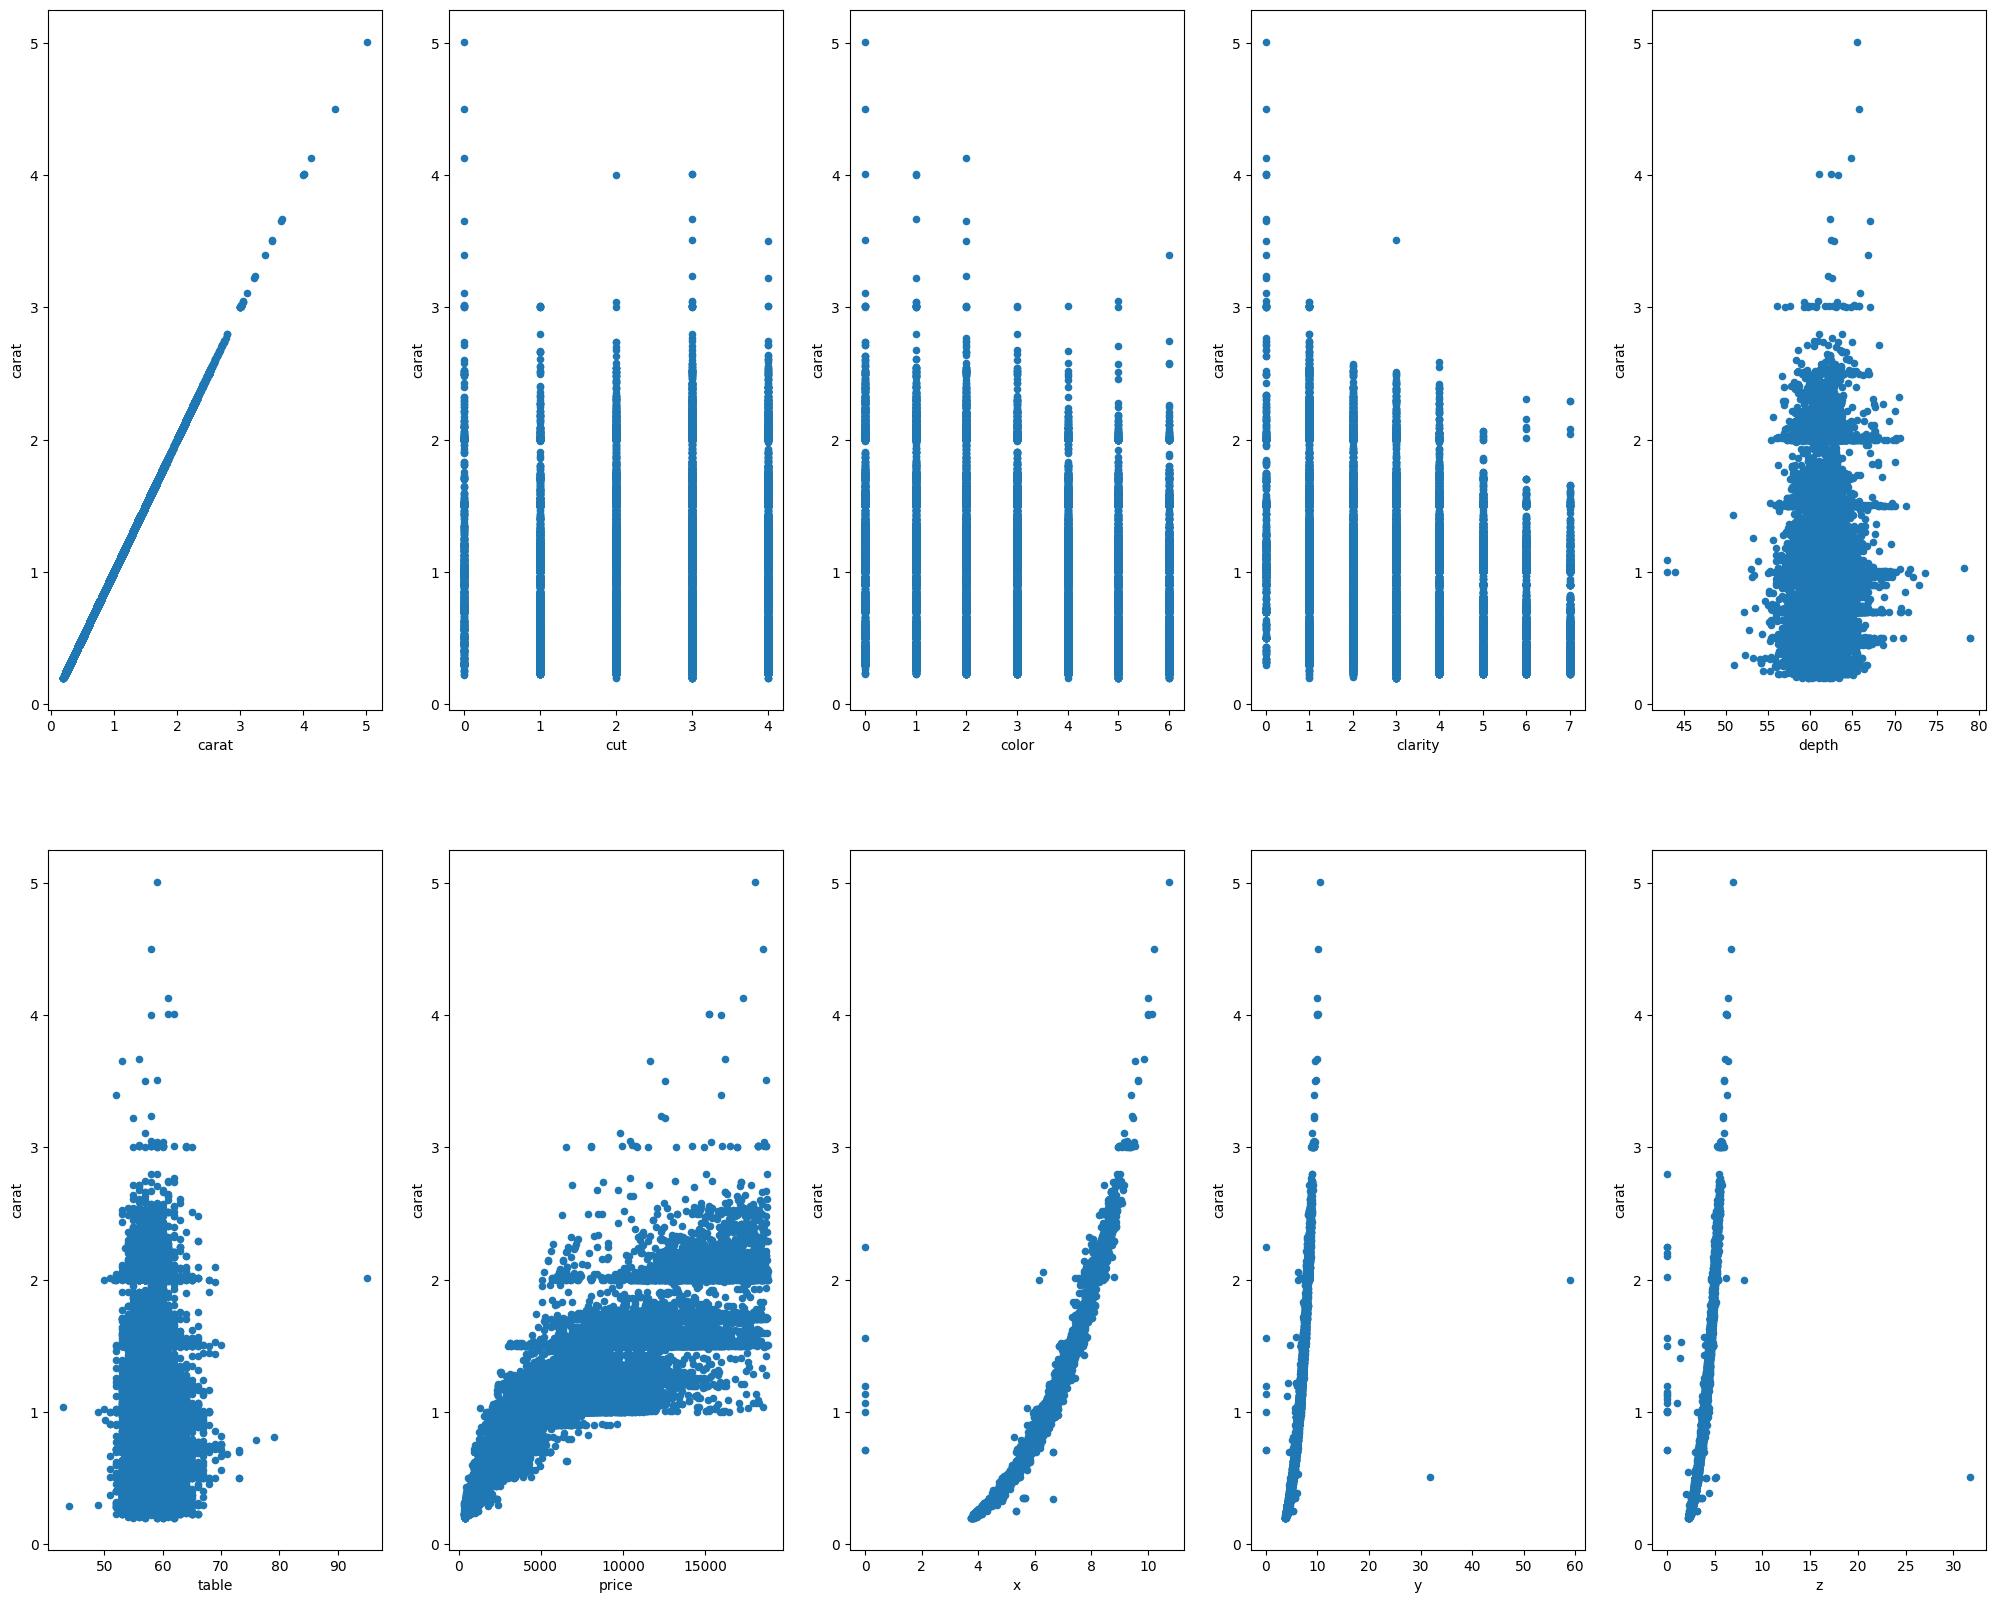

In [166]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 20))
for idx, feature in enumerate(df.columns):
    df.plot(feature, "carat", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])

При рассмотрении облаков точек параметров, сопоставленных стоимости бриллиантов, можно выделить нелинейную корелляцию стоимости и одного из габаритных размеров (х). Возможно, эта особенность поможет обучить модель более специфично.


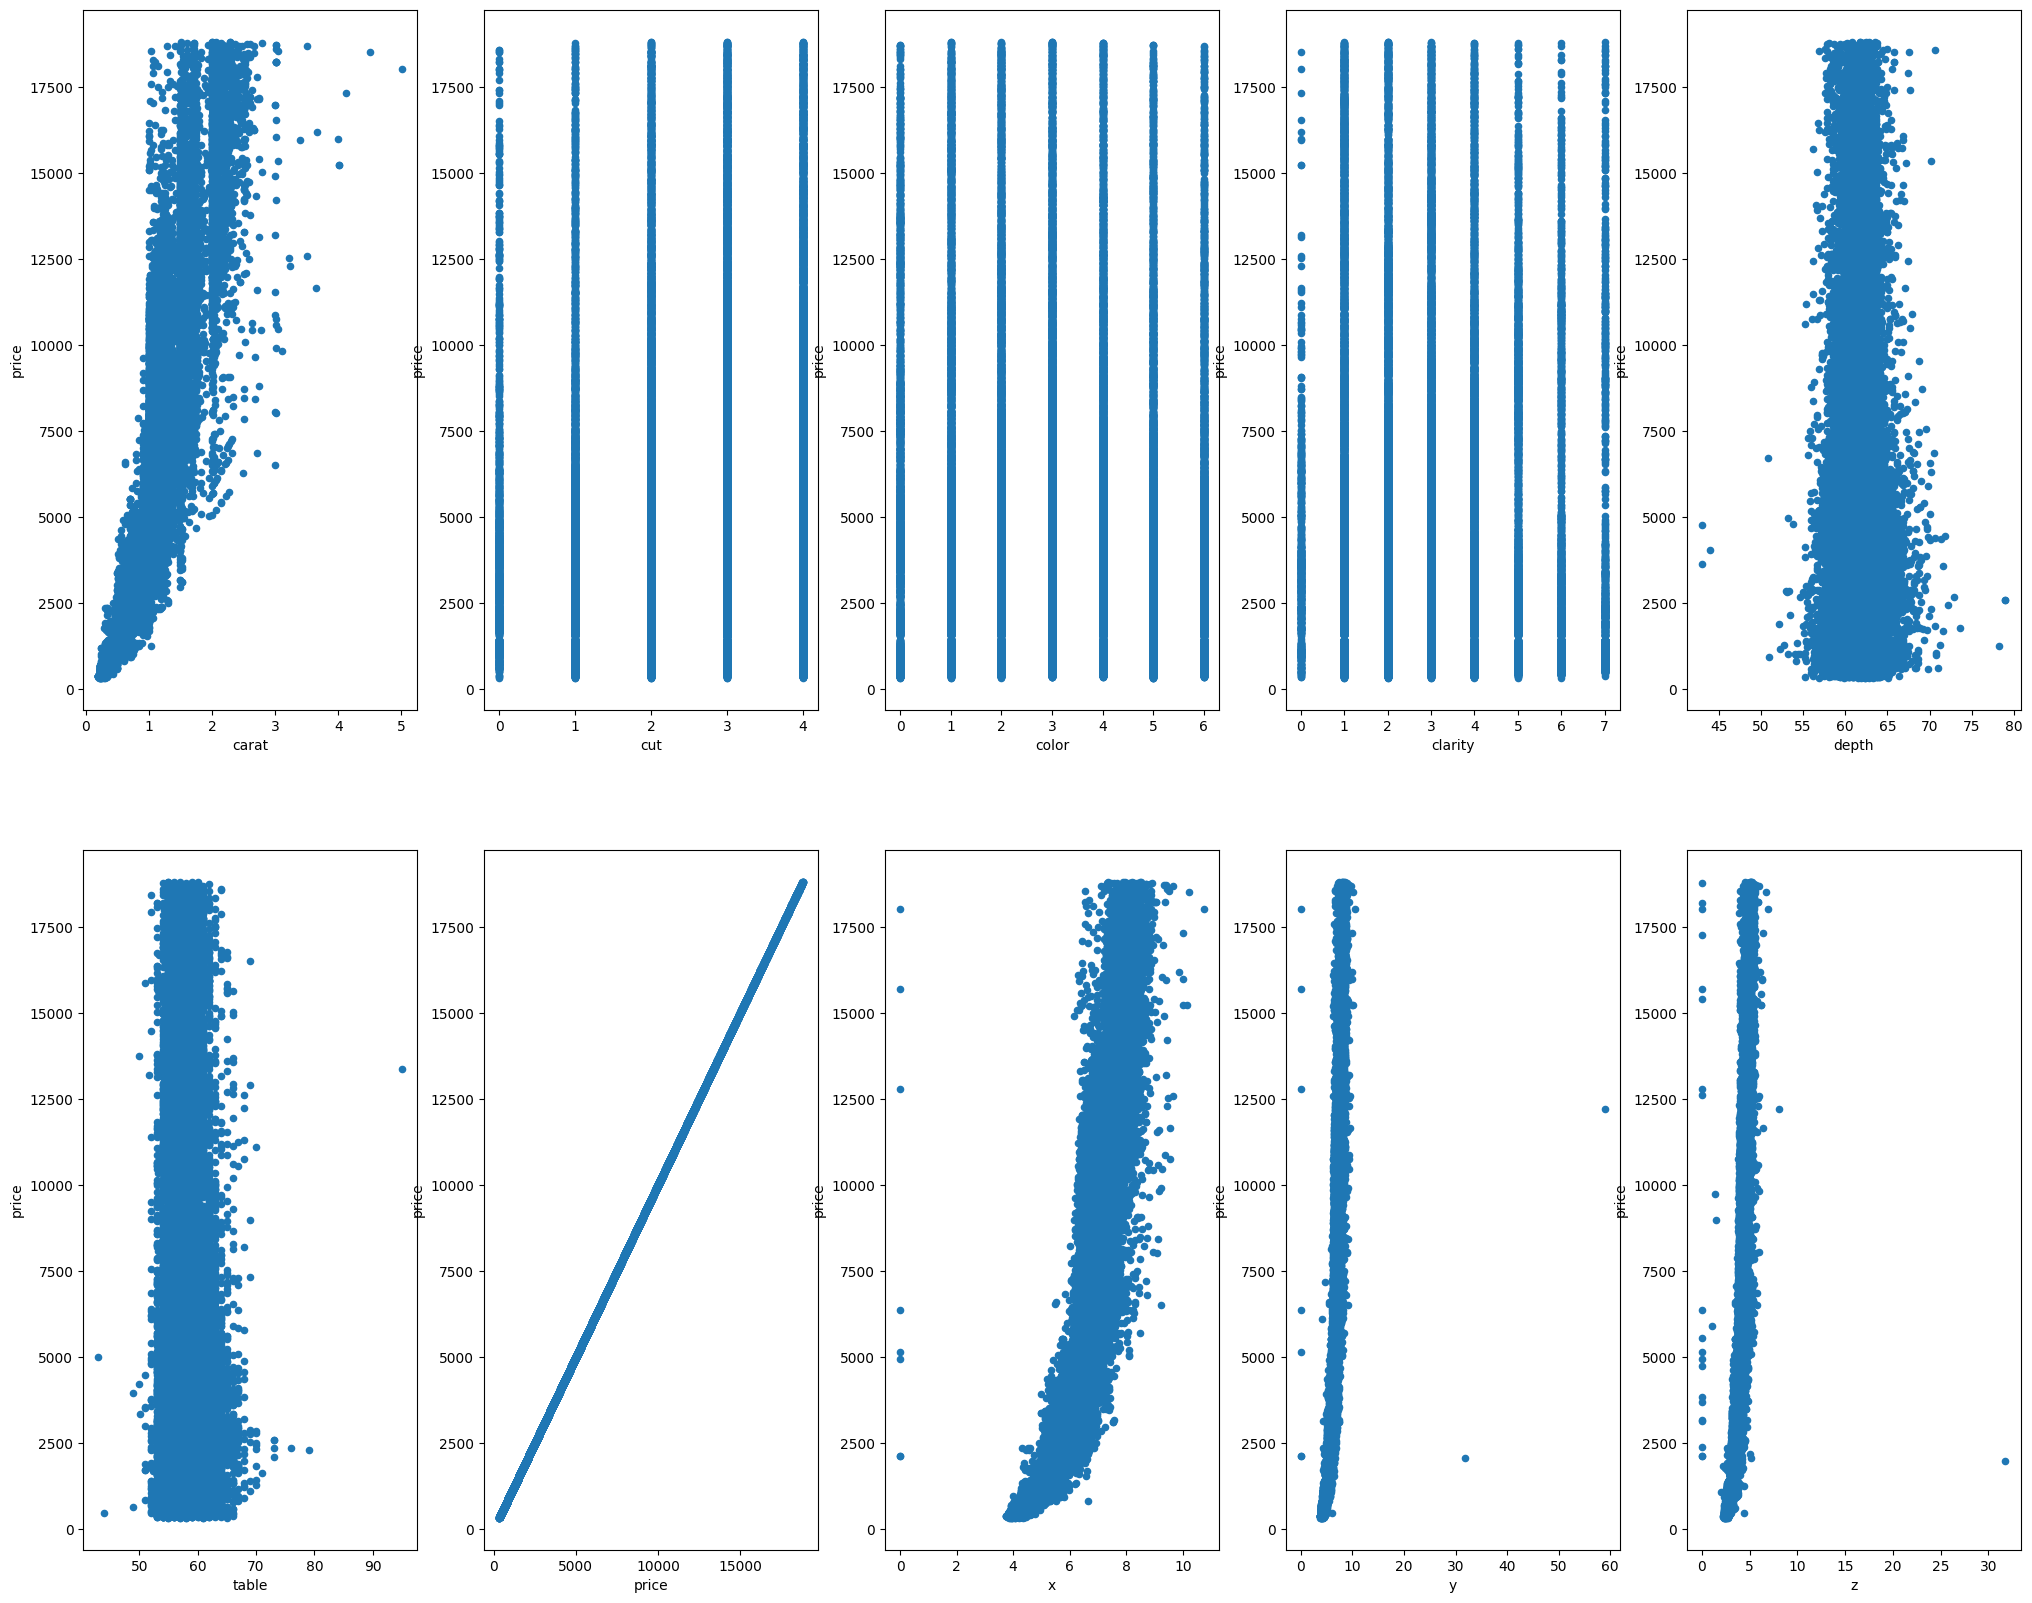

In [167]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 20))
for idx, feature in enumerate(df.columns):
    df.plot(feature, "price", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])

<Axes: xlabel='carat', ylabel='Density'>

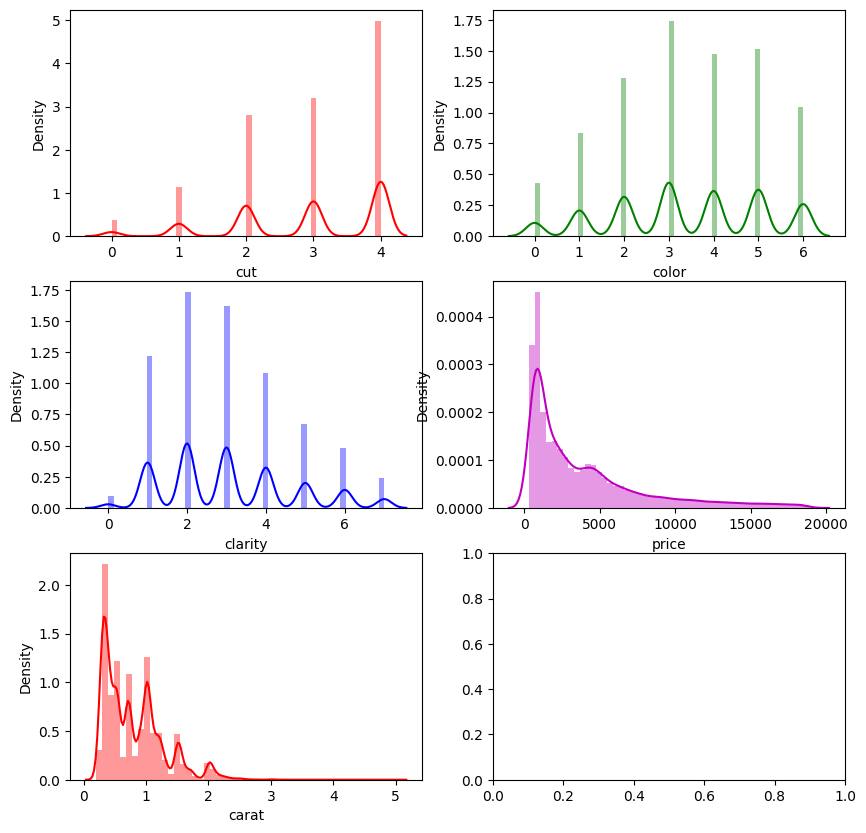

In [168]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
sns.distplot(df['cut'], bins=50, color='r', ax=axes[0, 0])
sns.distplot(df['color'], bins=50, color='g', ax=axes[0, 1])
sns.distplot(df['clarity'], bins=50, color='b', ax=axes[1, 0])
sns.distplot(df['price'], bins=50, color='m', ax=axes[1, 1])
sns.distplot(df['carat'], bins=50, color='r', ax=axes[2, 0])

In [169]:
y = df["color"]
x = df.drop('color',axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.25)

In [170]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train);

In [171]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train);

In [172]:
y_pred_dummy = dummy_clf.predict(x_test)
accuracy_score(y_test, y_pred_dummy)

0.20778642936596217

In [173]:
y_pred_log_reg = log_reg.predict(x_test)
accuracy_score(y_test, y_pred_log_reg)

0.2129032258064516

In [174]:
print( {precision_score(y_test, y_pred_dummy, average='macro', zero_division=0)})
print( {precision_score(y_test, y_pred_log_reg, average='macro', zero_division=0)})

{0.029683775623708882}
{0.06123619737468348}


In [175]:
print({f1_score(y_test, y_pred_dummy, average='macro')})
print({f1_score(y_test, y_pred_dummy, average='macro')})

{0.0491540141567771}
{0.0491540141567771}


In [176]:
print({fbeta_score(y_test, y_pred_dummy, average='macro', beta=2)})
print({fbeta_score(y_test, y_pred_log_reg, average='macro', beta=2)})

{0.08105246715379143}
{0.11972651836101432}


In [177]:
print({fbeta_score(y_test, y_pred_dummy, average='macro', beta=2000)})
print({fbeta_score(y_test, y_pred_log_reg, average='macro', beta=2000)})

{0.14285700669181267}
{0.15762150201427502}


In [183]:
y_pred = log_reg.predict_proba(x_test)[:, 1]

(13485,)

In [185]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

precision = precision_recall_curve(y_test, y_pred, pos_label='color')

no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

TypeError: 'bool' object is not subscriptable